In [1]:
import keras
from keras.layers import LSTM, Dense
from keras.models import Sequential
import numpy as np
import keras.backend as K

In [2]:
# stock data load
import pandas as pd
import os 

df = pd.read_csv('stock.csv')
df


,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


In [3]:
# data preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler_x.fit_transform(df[['Open', 'High', 'Low', 'Volume']])
df[['Close']] = scaler_y.fit_transform(df[['Close']])



In [4]:
df = pd.DataFrame(df, columns = ['Open', 'High', 'Low', 'Volume', 'Close'])

# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size = 0.3, shuffle=False, random_state=2023)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(512, 4) (512,) (220, 4) (220,)


In [5]:
# 5일 간의 데이터로 다음날의 종가를 예측하도록 데이터를 만들어줍니다.
def build_data(x_data, y_data, time_series):
    dataX = []
    dataY = []
    for i in range(len(x_data) - time_series):
        _x = x_data[i:i+time_series].values
        _y = y_data[i+time_series]
        
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)

In [6]:
train_x, train_y = build_data(X_train, y_train, 5)

X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

test_x, test_y = build_data(X_test, y_test, 5)

In [7]:
model = Sequential()
model.add(LSTM(20, input_shape = (5, 4)))
model.add(Dense(1 ))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2000      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(train_x, train_y, epochs = 300, batch_size = 32, verbose = 1)

Epoch 1/300
16/16 [==============================] - 3s 4ms/step - loss: 0.2653
Epoch 2/300
16/16 [==============================] - 0s 4ms/step - loss: 0.0471
Epoch 3/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 4/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 5/300
16/16 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 6/300
16/16 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 7/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 8/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 9/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 10/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 11/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 12/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 13/300
16/16 [=================

In [11]:
model.evaluate(test_x, test_y, batch_size = 32)


7/7 [==============================] - 0s 2ms/step - loss: 3.0506e-04


0.00030505924951285124

In [12]:
y_pred = model.predict(test_x)

7/7 [==============================] - 0s 1ms/step


In [16]:
y_pred_inverse = scaler_y.inverse_transform(np.array(y_pred))
y_true_inverse = scaler_y.inverse_transform(np.array(test_y).reshape(-1, 1))


In [17]:
from sklearn.metrics import mean_squared_error as mse
print(mse(y_true_inverse, y_pred_inverse))

35.91452813571543


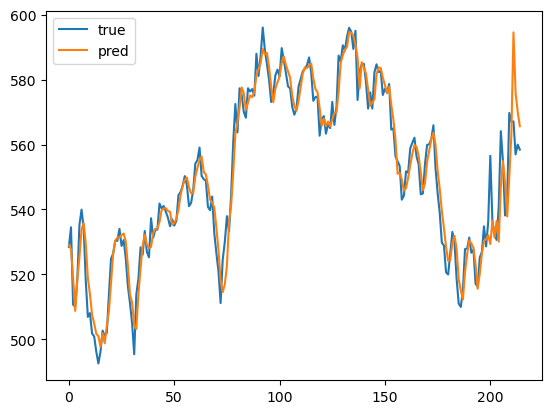

In [19]:
import matplotlib.pyplot as plt
plt.plot(y_true_inverse, label = 'true')
plt.plot(y_pred_inverse, label = 'pred')
plt.legend()
plt.show()